In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../../aparent/data/polyadb_features_pas_3_utr3_large.csv', sep='\t')

save_dict = np.load("../../../aparent/data/polyadb_features_pas_3_utr3_large_no_x.npz")
m, l = save_dict['m'], save_dict['l']

s = np.load('../predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3_large.npy')

#Mark a-rich sites
a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = np.array((df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175-70, 175-70+205).str.contains("AAAAAAAAA|AAAAAGAAAAA|AAAAACAAAAA|AAAAATAAAAA|AAAAAAGAAAA|AAAAAACAAAA|AAAAAATAAAA|AAAAGAAAAAA|AAAACAAAAAA|AAAATAAAAAA")).astype(int).values, dtype=np.int32)

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (193,194,196,200,201,203,207,208,210) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


s.shape = (12503, 30)
m.shape = (12503, 30)
l.shape = (12503, 30)


In [3]:
#Apply filters

min_total_l = 1
max_total_l = 1e9

min_l = np.min(l + (l == 0.) * 1e6, axis=-1)
max_l = np.max(l, axis=-1)

temp_dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

keep_index = np.nonzero((min_l >= min_total_l) & (max_l <= max_total_l))[0]

s = s[keep_index, :]
m = m[keep_index, :]
l = l[keep_index, :]
a_rich = a_rich[keep_index, :]

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("a_rich.shape = " + str(a_rich.shape))

print("# non-a-rich proximal sites = " + str(int(np.sum(1. - a_rich[:, 0]))))


s.shape = (12503, 30)
m.shape = (12503, 30)
l.shape = (12503, 30)
a_rich.shape = (12503, 30)
# non-a-rich proximal sites = 11734


In [4]:

l_prox_cumulative = np.log(np.cumsum(l[:, ::-1], axis=1) * m[:, ::-1] + 1.)[:, ::-1]
l_cumulative = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.log(l * m + 1.)


In [5]:

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

prox_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    prox_mask[i, prox_index[i]] = 1.

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [6]:
#Proximal-most vs Distal-most PAS scores (3' UTR)

s_utr3_dists = []
s_utr3_dist_means = []
s_utr3_dist_medians = []
s_utr3_dist_stds = []
for k in range(0, 30) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 and a_rich[i, dist_index[i] - k] == 0 :
            s_d.append(s[i, dist_index[i] - k] / np.log(2.))
    
    s_utr3_dists.append(np.array(s_d))
    
    if s_utr3_dists[-1].shape[0] > 1 :
        s_utr3_dist_means.append(np.mean(s_utr3_dists[-1]))
        s_utr3_dist_medians.append(np.median(s_utr3_dists[-1]))
        s_utr3_dist_stds.append(np.std(s_utr3_dists[-1]))
    else :
        s_utr3_dist_means.append(0.)
        s_utr3_dist_medians.append(0.)
        s_utr3_dist_stds.append(0.)

s_utr3_dist_means = np.array(s_utr3_dist_means)
s_utr3_dist_medians = np.array(s_utr3_dist_medians)
s_utr3_dist_stds = np.array(s_utr3_dist_stds)


In [7]:

s_dists = []
s_dist_colors = []
s_dist_names = []
for i, s_utr3 in enumerate(s_utr3_dists[::-1]) :
    s_dists.append(s_utr3)
    s_dist_colors.append('lightcoral')
    s_dist_names.append("-" + str(len(s_utr3_dists)-i-1) if i != len(s_utr3_dists) - 1 else "Distal PAS")


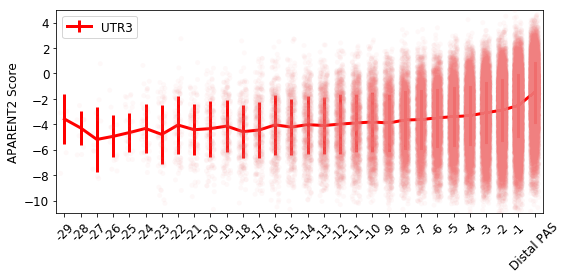

In [8]:
import seaborn as sns

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists, alpha=0.05, jitter=0.25, palette=s_dist_colors)

plt.errorbar(np.arange(30), s_utr3_dist_medians[::-1], yerr=s_utr3_dist_stds[::-1], linewidth=3, color='red', linestyle='-', label='UTR3')

plt.xlim(-0.5, 29.5)
plt.ylim(-11., 5.)

plt.xticks(
    np.arange(30),
    s_dist_names, fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT2 Score", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.show()


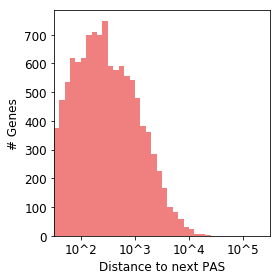

In [17]:
#Distribution of distance between proximal-most and next PAS (3' UTR sites only)

lf = l[a_rich[:, 0] == 0, ...]

x_vals = lf[:, 1] / np.log(10)

f = plt.figure(figsize=(4, 4))

plt.hist(x_vals, bins=40, range=(1.5, 5.5), color='lightcoral')

plt.xlim(1.5, 5.5)

plt.xticks([2, 3, 4, 5], ["10^2", "10^3", "10^4", "10^5"], fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Distance to next PAS", fontsize=12)
plt.ylabel("# Genes", fontsize=12)

plt.tight_layout()

plt.show()


SpearmanrResult(correlation=0.07839791727889427, pvalue=1.8233214507590727e-17)


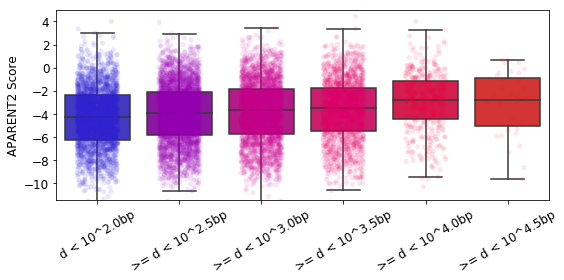

In [9]:
#Correlation between distance to next PAS and wildtype PAS score (3' UTR sites only)

from scipy.stats import spearmanr

lf = l[a_rich[:, 0] == 0, ...]
sf = s[a_rich[:, 0] == 0, ...]

print(spearmanr(lf[:, 1], sf[:, 0]))

x_vals = lf[:, 1] / np.log(10)
y_vals = sf[:, 0] / np.log(2.)

bins = [
    [1.5, 2.0],
    [2.0, 2.5],
    [2.5, 3.0],
    [3.0, 3.5],
    [3.5, 4.0],
    [4.0, 4.5],
]

colors = [
    '#2f22d8',
    '#9c00b8',
    '#ce0091',
    '#e80068',
    '#f20041',
    '#ee1919',
]

bin_names = []
y_dists = []
for i, [bin_start, bin_end] in enumerate(bins) :
    y_dists.append(y_vals[(x_vals >= bin_start) & (x_vals < bin_end)])
    
    if i == 0 :
        bin_names.append("d < " + "10^" + str(bin_end) + "bp")
    else :
        bin_names.append(">= d < " + "10^" + str(bin_end) + "bp")

import seaborn as sns

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=y_dists, alpha=0.1, jitter=0.25, palette=colors)
sns.boxplot(data=y_dists, showfliers=False, palette=colors)

plt.xlim(-0.5, 5.5)
plt.ylim(-11.5, 5.0)

plt.xticks(
    np.arange(6),
    bin_names, fontsize=12, rotation=30
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT2 Score", fontsize=12)

plt.tight_layout()

plt.show()


SpearmanrResult(correlation=0.07839791727889427, pvalue=1.8233214507590727e-17)


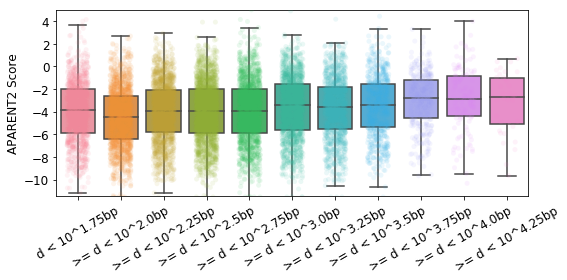

In [10]:
#Correlation between distance to next PAS and wildtype PAS score (smaller bin sizes, 3' UTR sites only)

from scipy.stats import spearmanr

lf = l[a_rich[:, 0] == 0, ...]
sf = s[a_rich[:, 0] == 0, ...]

print(spearmanr(lf[:, 1], sf[:, 0]))

x_vals = l[:, 1] / np.log(10)
y_vals = s[:, 0] / np.log(2.)

bins = [
    [1.5, 1.75],
    [1.75, 2.0],
    [2.0, 2.25],
    [2.25, 2.5],
    [2.5, 2.75],
    [2.75, 3.0],
    [3.0, 3.25],
    [3.25, 3.5],
    [3.5, 3.75],
    [3.75, 4.0],
    [4.0, 4.25],
]

bin_names = []
y_dists = []
for i, [bin_start, bin_end] in enumerate(bins) :
    y_dists.append(y_vals[(x_vals >= bin_start) & (x_vals < bin_end)])
    
    if i == 0 :
        bin_names.append("d < " + "10^" + str(bin_end) + "bp")
    else :
        bin_names.append(">= d < " + "10^" + str(bin_end) + "bp")

import seaborn as sns

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=y_dists, alpha=0.1, jitter=0.25)
sns.boxplot(data=y_dists, showfliers=False)

plt.xlim(-0.5, 10.5)
plt.ylim(-11.5, 5.0)

plt.xticks(
    np.arange(11),
    bin_names, fontsize=12, rotation=30
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT2 Score", fontsize=12)

plt.tight_layout()

plt.show()
